In [1]:
from keypoint_network import (build_kpextractor64, 
                              build_kpextractor128, 
                              build_kpextractor64_decoupled,
                              build_kpextractor128_decoupled,
                              build_kpextractor128_decoupled_stn,
                              build_kpextractor256_decoupled,
                              preproc_dataset)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join
import utool as ut
import plottool as pt


+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so
[!plotttool] WARNING guitool does not have __PYQT__


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
size = 128
model_loc = 'all_kpts_%d_fixedx_clean' % size
dset_loc = 'all_kpts_%d_fixedx' % size

In [3]:
#model_name = 'dec_nest_a2e-3_e100.pkl'
#model_name = 'model_adam.pkl'
model_name = 'model.pkl'
with open(join(dataset_loc, "Flukes/kpts/%s" % join(model_loc, model_name)), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_128_fixedx
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/meanstd.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/train.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/val.pkl')
[util_io] * load_cPkl(u'.../all_kpts_128_fixedx/test.pkl')
Took 0.44 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor128_decoupled()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((1.3260118, (16, 1, 3, 3)), conv1.W)),
 (1, ((0.36472723, (16,)), conv1.b)),
 (2, ((0.099623404, (16,)), beta)),
 (3, ((0.71118253, (16,)), gamma)),
 (4, ((0.30578458, (16,)), mean)),
 (5, ((118.78225, (16,)), inv_std)),
 (6, ((1.8942163, (32, 16, 3, 3)), conv2.W)),
 (7, ((0.38845149, (32,)), conv2.b)),
 (8, ((0.12357935, (32,)), beta)),
 (9, ((0.78664088, (32,)), gamma)),
 (10, ((0.29715267, (32,)), mean)),
 (11, ((155.45564, (32,)), inv_std)),
 (12, ((2.9114916, (64, 32, 3, 3)), conv3.W)),
 (13, ((0.55249071, (64,)), conv3.b)),
 (14, ((0.32872412, (64,)), beta)),
 (15, ((0.96624076, (64,)), gamma)),
 (16, ((0.26547769, (64,)), mean)),
 (17, ((378.78336, (64,)), inv_std)),
 (18, ((3.3858659, (128, 64, 3, 3)), conv4.W)),
 (19, ((1.1125574, (128,)), conv4.b)),
 (20, ((1.0323471, (128,)), beta)),
 (21, ((1.0142347, (128,)), gamma)),
 (22, ((0.29515496, (128,)), mean)),
 (23, ((889.08093, (128,)), inv_std)),
 (24, ((2.5743353, (256, 128, 3, 3)), conv5.W)),
 (25, ((2.3190222, (256,))

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in zip(enumerate(point_outputs['valid']),ll.get_all_layers(kpextractor))]

[(0, (1, 128, 128), 0.89308602, 'input'),
 (1, (16, 128, 128), 0.058043554, 'conv1'),
 (2, (16, 64, 64), 0.081613466, None),
 (3, (16, 64, 64), 0.14935099, None),
 (4, (32, 64, 64), 0.034540102, 'conv2'),
 (5, (32, 32, 32), 0.048606664, None),
 (6, (32, 32, 32), 0.11811297, None),
 (7, (64, 32, 32), 0.020347981, 'conv3'),
 (8, (64, 16, 16), 0.030336469, None),
 (9, (64, 16, 16), 0.091297641, None),
 (10, (128, 16, 16), 0.0077309986, 'conv4'),
 (11, (128, 8, 8), 0.01236969, None),
 (12, (128, 8, 8), 0.035303518, None),
 (13, (256, 8, 8), 0.004911216, 'conv5'),
 (14, (256, 4, 4), 0.0058770115, None),
 (15, (256, 4, 4), 0.0088907424, None),
 (16, (512, 4, 4), 0.017721746, 'conv6'),
 (17, (512, 2, 2), 0.025972314, None),
 (18, (512, 2, 2), 0.023267768, None),
 (19, (512, 2, 2), 0.023267768, None),
 (20, (256,), 0.075782493, None),
 (21, (256,), 0.053105034, None),
 (22, (256,), 0.053105034, None),
 (23, (32,), 0.067247465, None),
 (24, (2,), 0.1006583, None),
 (25, (32,), 0.063710093, None

In [7]:
print(np.std(point_outputs['valid'][11],axis=0))

[[[ 0.01424803  0.00162062  0.00793118 ...,  0.00389161  0.02076273
    0.00497032]
  [ 0.0293437   0.01765532  0.00263778 ...,  0.00489492  0.01916817
    0.00405004]
  [ 0.04372215  0.02132497  0.00523649 ...,  0.00433437  0.01120545
    0.00267326]
  ..., 
  [ 0.02403861  0.0119931   0.01346018 ...,  0.00779179  0.00867975
    0.00448342]
  [ 0.02093943  0.01062459  0.00953467 ...,  0.00965143  0.00663617
    0.00521727]
  [ 0.01262149  0.0094581   0.00667218 ...,  0.00605696  0.00496867
    0.00554713]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.  

/home/zach/data/Flukes/CRC_combined constrained/20120612-MBWW-8352.jpg
(318, 960)
[[  52.5         7.453125]
 [ 907.5         9.9375  ]
 [ 480.        211.171875]]
[[   7.    3.]
 [ 121.    4.]
 [  64.   85.]]
[[  56.04228592    8.97949409]
 [ 908.16278076   14.15674114]
 [ 477.99346924  211.13696289]]
[[   7.47230482    3.61438751]
 [ 121.08837128    5.69831085]
 [  63.73246384   84.98594666]]
[ 3.85714817  4.27098036  2.00683451]
[ 0.77494764  1.70060849  0.26790503]


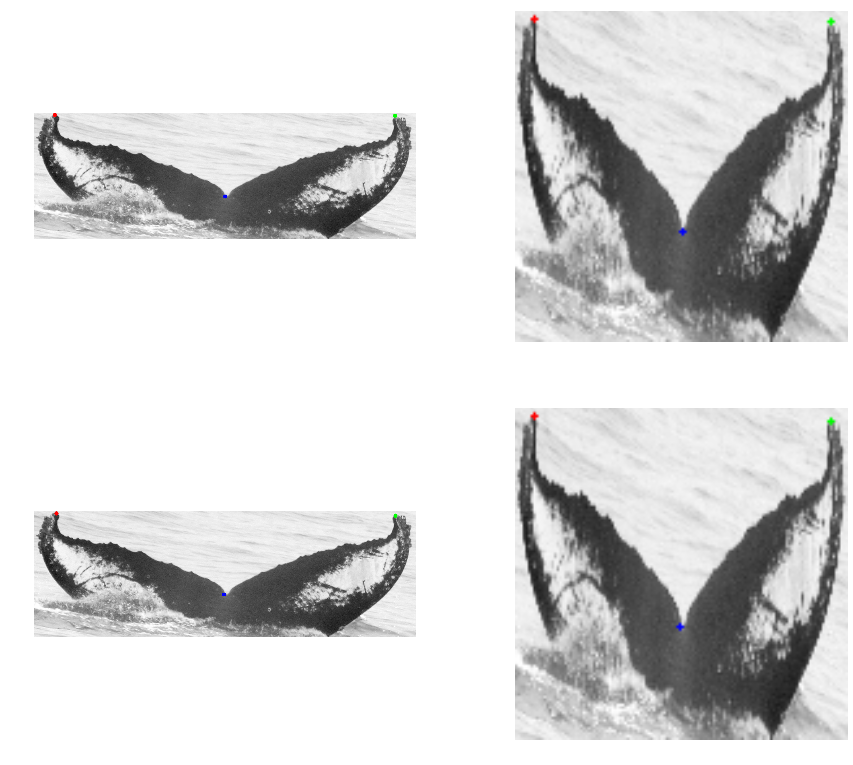

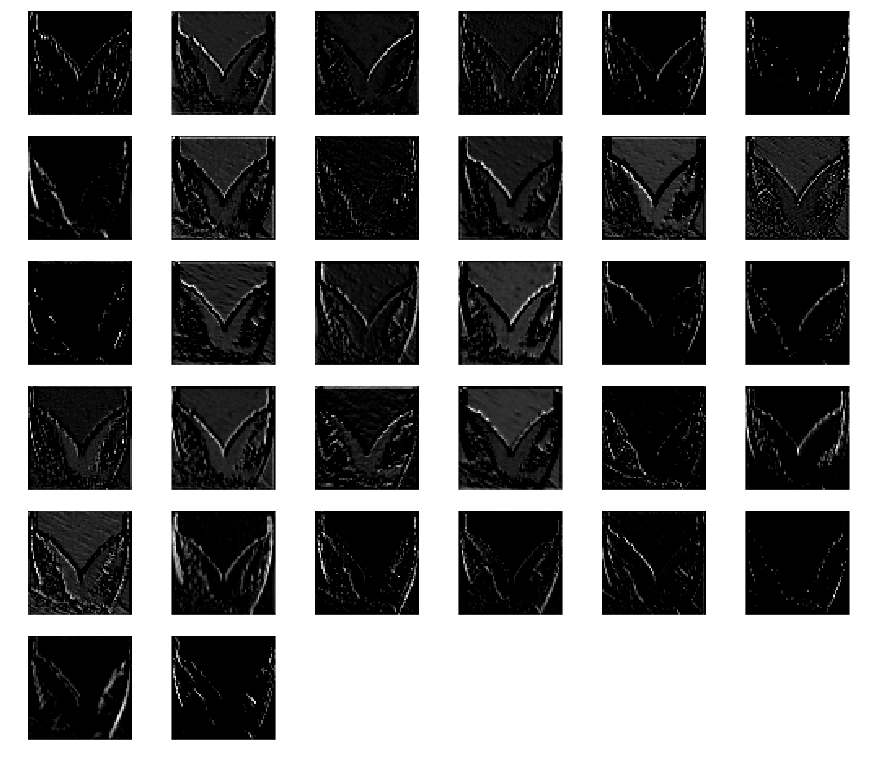

In [8]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img, radius=5):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), radius, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), radius, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), radius, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None, sizes=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dsety, dsetx = dset_img.shape[:2]
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    if sizes is not None:
        original_img = cv2.resize(original_img, tuple(sizes[ind][::-1]), cv2.INTER_LANCZOS4)
    print(original_img.shape)
    origy, origx = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.array([origx, origy]*3,dtype=np.float32).reshape(3,2)
    scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_points * (scale_num_orig / scale_denom)
    true_points_dset = true_points * (scale_num_dset / scale_denom)
    print(true_points_orig)
    print(true_points_dset)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    orig_gt_drawn = drawPoints(true_points_orig, original_img)
    dset_gt_drawn = drawPoints(true_points_dset, dset_img, radius=1)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_orig = pred_points * (scale_num_orig / scale_denom)
    pred_points_dset = pred_points * (scale_num_dset / scale_denom)
    print(pred_points_orig)
    print(pred_points_dset)
    pred_drawn_orig = drawPoints(pred_points_orig, original_img)
    pred_drawn_dset = drawPoints(pred_points_dset, dset_img, radius=1)
    print(np.linalg.norm(true_points_orig - pred_points_orig, axis=1))
    print(np.linalg.norm(true_points_dset - pred_points_dset, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(orig_gt_drawn)
    trueax[0,1].imshow(dset_gt_drawn)
    trueax[1,0].imshow(pred_drawn_orig)
    trueax[1,1].imshow(pred_drawn_dset)
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    if square_size > 1:
        f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
        for i in range(square_size*square_size):
            #netax.set_gray()
            this_ax = netax[i // square_size, i % square_size]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'test'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=4, 
            imgnames=dset_for_model[sec]['names'], sizes=dset_for_model[sec]['extra'])

[[ 0.065752    0.14095853]
 [ 0.92283714  0.14325482]
 [ 0.49169362  0.51416898]]
[[ 0.06894159  0.1380267 ]
 [ 0.92450011  0.14547941]
 [ 0.4907611   0.51261312]]
0.019598
0.0960964
0.0986617


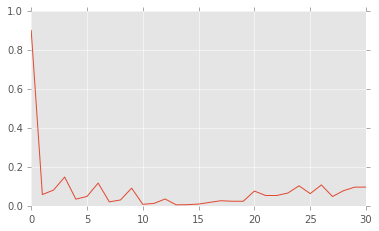

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

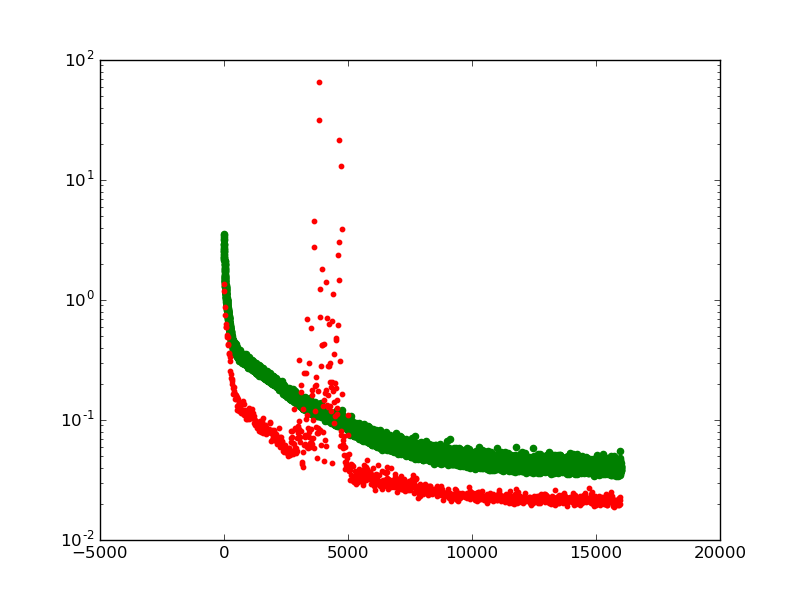

In [10]:
from IPython.display import Image 
Image(filename='./losses.png')

In [11]:
# let's see the worst cases by original size
sec = 'test'
def get_gt_dist(true_pt, pred_pt, sizes):
    #sizey, sizex = (1.,1.)
    sizes = sizes[:,::-1]
    #scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.stack([sizes, sizes, sizes],axis=1).astype(np.float32)
    #scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_pt * (scale_num_orig)
    #true_points_dset = true_points * (scale_num_dset / scale_denom)
    pred_points_orig = pred_pt * (scale_num_orig)
    dists = np.linalg.norm(true_points_orig - pred_points_orig, axis=2)
    #print(dists)
    return dists

gt_dists = get_gt_dist(dset_for_model[sec]['y'], point_outputs[sec][-1], dset_for_model[sec]['extra'])

In [12]:
sorted_by_dist = sorted(zip(gt_dists, list(range(dset_for_model[sec]['X'].shape[0]))), key=lambda x: np.average(x[0]))
dists, ind_sorted = zip(*sorted_by_dist)
sorted_X = dset_for_model[sec]['X'][ind_sorted,:]
sorted_y = dset_for_model[sec]['y'][ind_sorted,:]
sorted_pred = [stage[ind_sorted,:] for stage in point_outputs[sec]]
sorted_names = [dset_for_model[sec]['names'][ind] for ind in ind_sorted]
sorted_sizes = dset_for_model[sec]['extra'][ind_sorted,:]

/home/zach/data/Flukes/Flukebook/images/extract2b4fa489-961c-468e-a185-73529df57365.jpg
(720, 960)
[[ 645.     478.125]
 [ 810.     466.875]
 [ 720.     500.625]]
[[  86.   85.]
 [ 108.   83.]
 [  96.   89.]]
[[ 726.26953125  577.08544922]
 [ 821.96661377  500.93539429]
 [ 767.46105957  524.67529297]]
[[  96.8359375   102.5929718 ]
 [ 109.59555054   89.05518341]
 [ 102.32814026   93.27561188]]
[ 128.05432129   36.10139084   53.20684814]
[ 20.66228867   6.26187086   7.6371603 ]


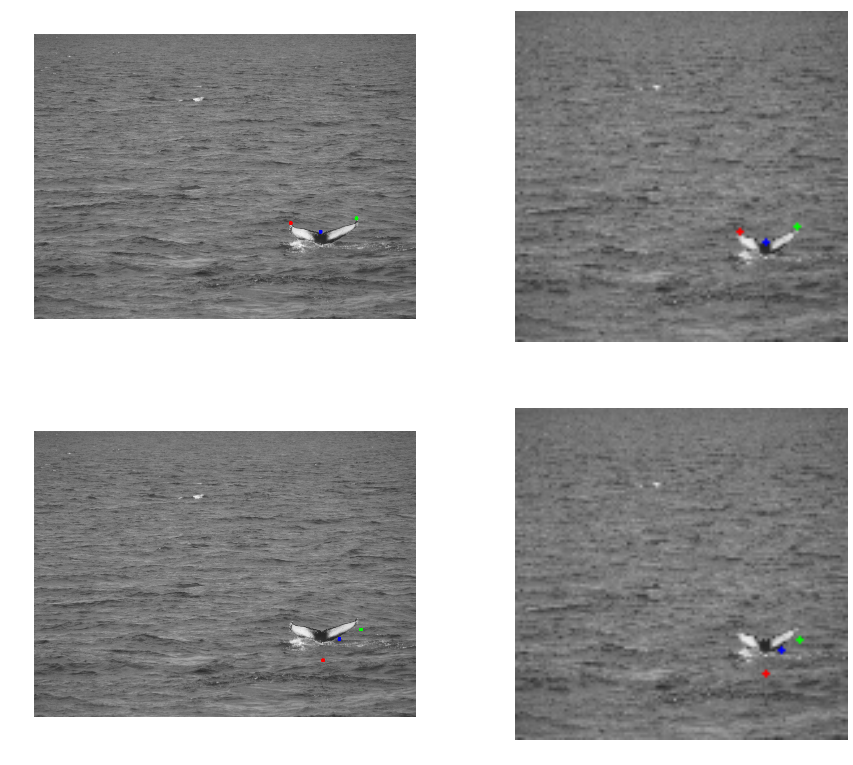

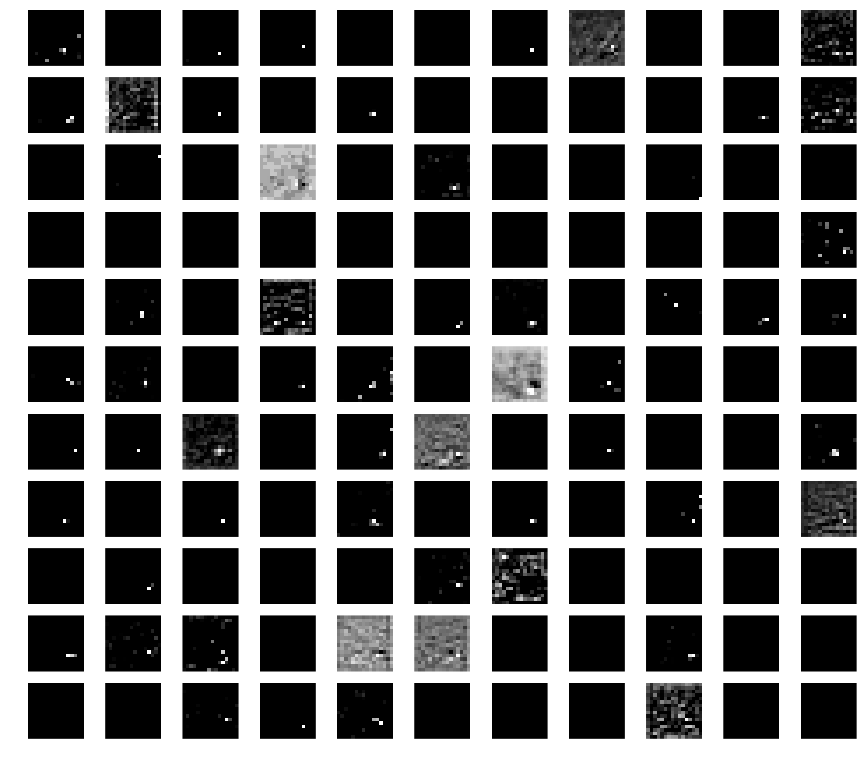

In [13]:
show_output(sorted_X, sorted_y, sorted_pred, -10, stage=10, imgnames=sorted_names, sizes=sorted_sizes)

1.0


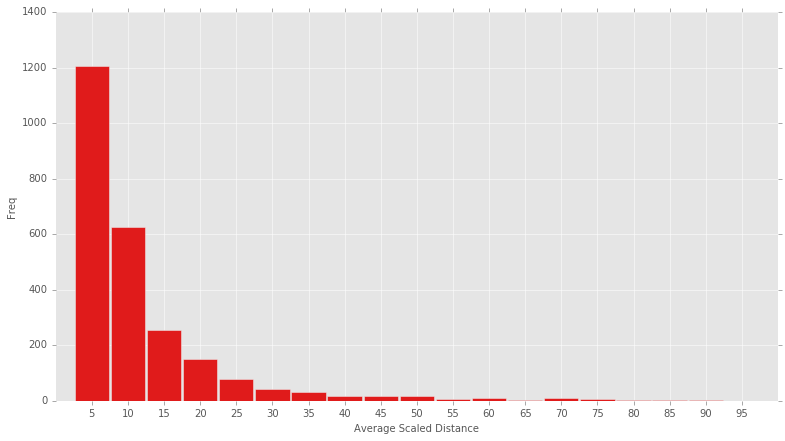

In [24]:
dists = np.vstack(dists)
dists_over = dists[np.average(dists,axis=1) > 0]
print(float(dists_over.shape[0]) / dists.shape[0])
hist, bin_edges = np.histogram(dists, bins=range(5,100,5))
pt.draw_histogram(bin_edges, hist, xlabel='Average Scaled Distance', autolabel=False)

import matplotlib.pyplot as plt
plt.gcf()
plt.savefig("/home/zach/data/results/kp128_test_dist_hist.png")

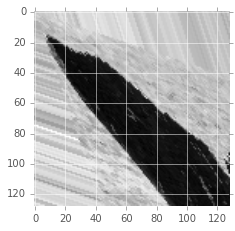

In [15]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))